# Neuromatch Academy: Week 2, Day 5, Tutorial 2

# VAEs and GANs : Density Ratio Estimation Perpective of GAN

__Content creators:__ Kai Xu, Seungwook Han, Akash Srivastava

__Content reviewers:__ Name Surname, Name Surname. 

__Content editors:__ Name Surname, Name Surname.

__Production editors:__ Name Surname, Name Surname.  

---

## Tutorial Objectives

The goal of this tutorial is to understand how GANs are connected to other generative models that we have been before.

By the end of this tutorial you will be able to:
- Understand density ratio estimation using a binary classifier
- Understand the connection between GANs and other generative models.
- Implement a GAN

In [1]:
#@markdown Tutorial slides
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/1hTTB8viooNQLPdV7DpjsOAP16e6RcP5L" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup

In [2]:
#@title Imports
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
#@title Figure settings
from IPython.display import display, clear_output, HTML, SVG
import ipywidgets # interactive display
from ipywidgets import Layout
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

class Interactive:
  def display_widgets(self):
    for widget in self.widgets:
      display(widget)

  def __init__(self, widgets, handler):
    def handler_with_extra_steps(b):
      clear_output(wait=True)
      handler(*map(lambda w: w.value, widgets))
      self.display_widgets()
    self.widgets = widgets
    for widget in self.widgets:
      widget.observe(handler_with_extra_steps, names=['value'])
    handler(*map(lambda w: w.value, widgets))
    self.display_widgets()

# Using Interactive
# All widgets: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html

def make_plot(xmax, title, ftype):
  fig, ax = plt.subplots()
  x = np.linspace(-2, xmax, 100)
  if ftype == "sin":
    y = np.sin(x)
  if ftype == "cos":
    y = np.cos(x)
  if ftype == "tanh":
    y = np.tanh(x)
  ax.scatter(x, y)
  ax.set_xlim(-2.1, 2.1)
  ax.set_ylim(-2, 2)
  if title:
    ax.set_title(f"Range from -1 to {xmax}")
  return fig

# slider_xmax = ipywidgets.FloatSlider(value=0.0, min=-2.0, max=2.0)
# checkbox_title = ipywidgets.Checkbox(value=False, description="Show title")
# toggle_buttons_ftype = ipywidgets.ToggleButtons(
#     options=['sin', 'cos', 'tanh'],
#     description='Type of function:',
# )
# Interactive([slider_xmax, checkbox_title, toggle_buttons_ftype], make_plot)

In [4]:
#@title Plotting functions

# You may have functions that plot results that aren't 
# particularly interesting. You can add these here to hide them. 

ld_true = [-7.0066e-01, -2.6368e-01, -2.4250e+00, -2.0247e+00, -1.1795e+00,
        -4.5558e-01, -7.1316e-01, -1.0932e-01, -7.8608e-01, -4.5838e-01,
        -1.0530e+00, -9.1201e-01, -3.8020e+00, -1.7787e+00, -1.2246e+00,
        -6.5677e-01, -3.6001e-01, -2.2313e-01, -1.8262e+00, -1.2649e+00,
        -3.8330e-01, -8.8619e-02, -9.2357e-01, -1.3450e-01, -8.6891e-01,
        -5.9257e-01, -4.8415e-02, -3.3197e+00, -1.6862e+00, -9.8506e-01,
        -1.1871e+00, -7.0422e-02, -1.7378e+00, -1.3099e+00, -1.8926e+00,
        -3.4508e+00, -1.5696e+00, -7.2787e-02, -3.2420e-01, -2.9795e-01,
        -6.4189e-01, -1.4120e+00, -5.3684e-01, -3.4066e+00, -1.9753e+00,
        -1.4178e+00, -2.0399e-01, -2.3173e-01, -1.2792e+00, -7.2990e-01,
        -1.9872e-01, -2.9378e-03, -3.5890e-01, -5.6643e-01, -1.8003e-01,
        -1.5818e+00, -5.2227e-01, -2.1862e+00, -1.8743e+00, -1.4200e+00,
        -3.1988e-01, -3.5513e-01, -1.5905e+00, -4.2916e-01, -2.5556e-01,
        -8.2807e-01, -6.5568e-01, -4.8475e-01, -2.1049e-01, -2.0104e-02,
        -2.1655e+00, -1.1496e+00, -3.6168e-01, -8.9624e-02, -6.7098e-02,
        -6.0623e-02, -5.1165e-01, -2.7302e+00, -6.0514e-01, -1.6756e+00,
        -3.3807e+00, -5.7368e-02, -1.2763e-01, -6.6959e+00, -5.2157e-01,
        -8.7762e-01, -8.7295e-01, -1.3052e+00, -3.6777e-01, -1.5904e+00,
        -3.8083e-01, -2.8388e-01, -1.5323e-01, -3.7549e-01, -5.2722e+00,
        -1.7393e+00, -2.8814e-01, -5.0310e-01, -2.2077e+00, -1.5507e+00,
        -6.8569e-01, -1.4620e+00, -9.2639e-02, -1.4160e-01, -3.6734e-01,
        -1.0053e+00, -6.7353e-01, -2.2676e+00, -6.0812e-01, -1.0005e+00,
        -4.2908e-01, -5.1369e-01, -2.2579e-02, -1.8496e-01, -3.4798e-01,
        -7.3089e-01, -1.1962e+00, -1.6095e+00, -1.7558e-01, -3.3166e-01,
        -1.1445e+00, -2.4674e+00, -5.0600e-01, -2.0727e+00, -5.4371e-01,
        -8.0499e-01, -3.0521e+00, -3.6835e-02, -2.0485e-01, -4.6747e-01,
        -3.6399e-01, -2.6883e+00, -1.9348e-01, -3.1448e-01, -1.6332e-01,
        -3.2233e-02, -2.3336e-01, -2.6564e+00, -1.2841e+00, -1.3561e+00,
        -7.4717e-01, -2.7926e-01, -8.7849e-01, -3.3715e-02, -1.4933e-01,
        -2.7738e-01, -1.6899e+00, -1.5758e+00, -3.2608e-01, -6.5770e-01,
        -1.7136e+00, -5.8316e+00, -1.1988e+00, -8.3828e-01, -1.8033e+00,
        -2.3017e-01, -8.9936e-01, -1.1917e-01, -1.6659e-01, -2.7669e-01,
        -1.2955e+00, -1.2076e+00, -2.2793e-01, -1.0528e+00, -1.4894e+00,
        -5.7428e-01, -7.3208e-01, -9.5673e-01, -1.6617e+00, -3.9169e+00,
        -1.2182e-01, -3.8092e-01, -1.1924e+00, -2.4566e+00, -2.7350e+00,
        -2.8332e+00, -9.1506e-01, -6.7432e-02, -7.8965e-01, -2.0727e-01,
        -3.4615e-02, -2.8868e+00, -2.1218e+00, -1.2368e-03, -9.0038e-01,
        -5.3746e-01, -5.4080e-01, -3.1625e-01, -1.1786e+00, -2.2797e-01,
        -1.1498e+00, -1.3978e+00, -1.9515e+00, -1.1614e+00, -5.1456e-03,
        -1.9316e-01, -1.3849e+00, -9.2799e-01, -1.1649e-01, -2.3837e-01]

def plotting_ld(ld):
  fig, ax = plt.subplots(figsize=(7, 7))
  ax.plot([-6, 1], [-6, 1], label="Ground Truth")
  ax.scatter(ld_true, ld, marker="x", label="Your implementation")
  ax.set_xlabel("Loss from oracle implementation")
  ax.set_ylabel("Loss from your implementation")
  ax.legend()
  ax.set_title("Discriminator Loss")

lg_true = [-7.0066e-01, -2.6368e-01, -2.4250e+00, -2.0247e+00, -1.1795e+00,
        -4.5558e-01, -7.1316e-01, -1.0932e-01, -7.8608e-01, -4.5838e-01,
        -1.0530e+00, -9.1201e-01, -3.8020e+00, -1.7787e+00, -1.2246e+00,
        -6.5677e-01, -3.6001e-01, -2.2313e-01, -1.8262e+00, -1.2649e+00,
        -3.8330e-01, -8.8619e-02, -9.2357e-01, -1.3450e-01, -8.6891e-01,
        -5.9257e-01, -4.8415e-02, -3.3197e+00, -1.6862e+00, -9.8506e-01,
        -1.1871e+00, -7.0422e-02, -1.7378e+00, -1.3099e+00, -1.8926e+00,
        -3.4508e+00, -1.5696e+00, -7.2787e-02, -3.2420e-01, -2.9795e-01,
        -6.4189e-01, -1.4120e+00, -5.3684e-01, -3.4066e+00, -1.9753e+00,
        -1.4178e+00, -2.0399e-01, -2.3173e-01, -1.2792e+00, -7.2990e-01,
        -1.9872e-01, -2.9378e-03, -3.5890e-01, -5.6643e-01, -1.8003e-01,
        -1.5818e+00, -5.2227e-01, -2.1862e+00, -1.8743e+00, -1.4200e+00,
        -3.1988e-01, -3.5513e-01, -1.5905e+00, -4.2916e-01, -2.5556e-01,
        -8.2807e-01, -6.5568e-01, -4.8475e-01, -2.1049e-01, -2.0104e-02,
        -2.1655e+00, -1.1496e+00, -3.6168e-01, -8.9624e-02, -6.7098e-02,
        -6.0623e-02, -5.1165e-01, -2.7302e+00, -6.0514e-01, -1.6756e+00,
        -3.3807e+00, -5.7368e-02, -1.2763e-01, -6.6959e+00, -5.2157e-01,
        -8.7762e-01, -8.7295e-01, -1.3052e+00, -3.6777e-01, -1.5904e+00,
        -3.8083e-01, -2.8388e-01, -1.5323e-01, -3.7549e-01, -5.2722e+00,
        -1.7393e+00, -2.8814e-01, -5.0310e-01, -2.2077e+00, -1.5507e+00]

def plotting_lg(lg):
  fig, ax = plt.subplots(figsize=(7, 7))
  ax.plot([-6, 1], [-6, 1], label="Ground Truth")
  ax.scatter(lg_true, lg, marker="x", label="Your implementation")
  ax.set_xlabel("Loss from oracle implementation")
  ax.set_ylabel("Loss from your implementation")
  ax.legend()
  ax.set_title("Generator loss")

def plotting_ratio_impl(ax, x_real, x_fake, ratio, yscale="linear"):
  dist_p = torch.distributions.normal.Normal(loc=0, scale=1)
  dist_q = torch.distributions.normal.Normal(loc=-2, scale=1)
  x = torch.linspace(-3, 5, 100)
  prob_p = torch.exp(dist_p.log_prob(x))
  prob_q = torch.exp(dist_q.log_prob(x))
  trueRatio = prob_p / prob_q
  ax.plot(x, trueRatio, label="True tatio")
  
  x = torch.cat([x_real, x_fake])
  ax.scatter(x[:,0][::10], ratio[:,0][::10], marker="x", label="Ratio from discriminator")
  ax.hist(x_real[:,0], density=True, bins=50, histtype="step", label="Real")
  ax.hist(x_fake[:,0], density=True, bins=50, histtype="step", label="Fake")
  ax.set_yscale(yscale)
  title = "Densities and the ratio from discriminator"
  if yscale == "log":
    title += " in log scale"
  ax.set_title(title)
  ax.legend()

def plotting_ratio(x_real, x_fake, ratio):
  fig, axes = plt.subplots(1, 2, figsize=(2 * 7, 7))
  plotting_ratio_impl(axes[0], x_real, x_fake, ratio, yscale="linear")
  plotting_ratio_impl(axes[1], x_real, x_fake, ratio, yscale="log")

In [5]:
#@title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell

---

# Section 1: GAN Training Objective

The training objectives of GANs consist the losses for generators and discriminators respectively. In this section we will be implementing these objectives.

Video available at https://youtu.be/4QCmwCdJcQs


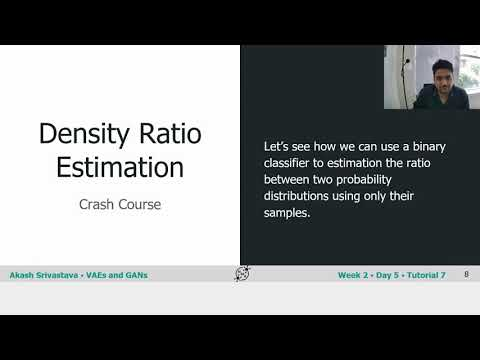

In [6]:
#@title Video 1: GAN Losses
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="4QCmwCdJcQs", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Section 1.1:  Discriminator Loss

Critic or the discriminator in a vanilla GAN is trained as a binary classifier. In this section we will implement the training objective for the discriminator.

### Coding Exercise 1.1: Implement Discriminator Loss

To get you started we have implemented a simple GAN in pseudocode and partially implemented the discriminator training objective.

__Your goal__ is to complete the missing part in the training objective of the discriminator in the function `loss_disc`.

`disc.loss` also allows you evaluate the loss function on some random samples.
If your implementation is correct, you will see a plot where the loss values from your implementation will match the ground truth loss values.

In [7]:
# @markdown *Execute this cell to enable helper functions*

def get_data(num_samples=100, seed=0):
  torch.manual_seed(seed)
  return torch.randn([num_samples,1])

class DummyGen:
  def sample(self, num_samples=100, seed=1):
    torch.manual_seed(seed)
    return torch.randn([num_samples,1]) + 2

class DummyDisc:
  def classify(self, x, seed=0):
    torch.manual_seed(seed)
    return torch.rand([x.shape[0],])

In [8]:
def loss_disc(disc, x_real, x_fake):
  """Compute the discriminator loss for `x_real` and `x_fake` given `disc`
  
  Args:
    disc: The discriminator
    x_real (ndarray): An array of shape (N,) that contains the real samples
    x_fake (ndarray): An array of shape (N,) that contains the fake samples

  Returns:
    ndarray: The discriminator loss
  """
  #################################################
  # Intructions for students:                            #
  # Fill out [TODO] in the function and remove below #
  #################################################

  #################################################
  # TODO for students: Loss for real data
  #################################################
  label_real = 1
  loss_real = label_real * ...
  raise NotImplementedError("Student exercise: Implement loss for real samples")
  #################################################
  # TODO for students: Loss for fake data
  #################################################
  label_fake = 0
  loss_fake = ... * torch.log(1 - disc.classify(x_fake))
  raise NotImplementedError("Student exercise: Implement loss for fake samples")
  
  return loss_real + loss_fake

In [9]:
# to_remove solution
def loss_disc(disc, x_real, x_fake):
  """Compute the discriminator loss for `x_real` and `x_fake` given `disc`
  
  Args:
    disc: The discriminator
    x_real (ndarray): An array of shape (N,) that contains the real samples
    x_fake (ndarray): An array of shape (N,) that contains the fake samples

  Returns:
    ndarray: The discriminator loss
  """

  # Loss for real data
  label_real = 1
  loss_real = label_real * torch.log(disc.classify(x_real))

  # Loss for fake data
  label_fake = 0
  loss_fake = (1 - label_fake) * torch.log(1 - disc.classify(x_fake))

  return torch.cat([loss_real, loss_fake])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


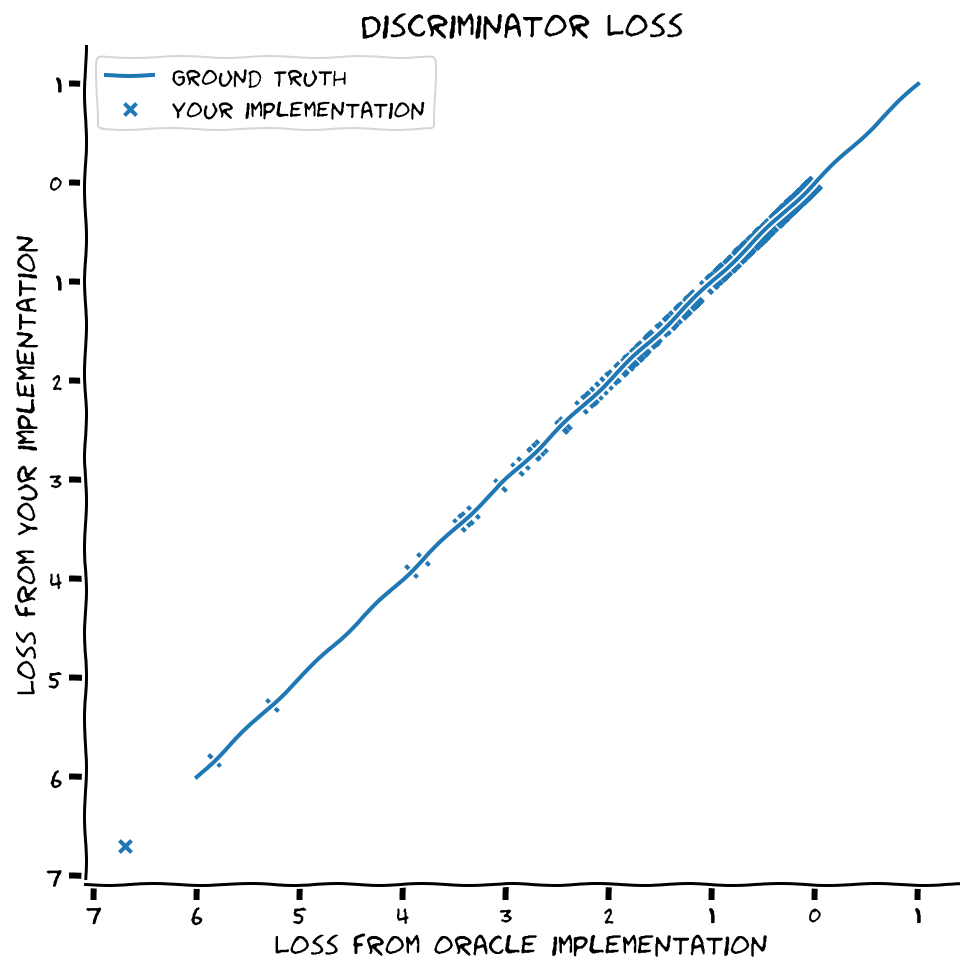

In [10]:
disc = DummyDisc()
gen = DummyGen()

x_real = get_data()
x_fake = gen.sample()
ld = loss_disc(disc, x_real, x_fake)

with plt.xkcd():  
  plotting_ld(ld)

#### A note on numerical stability

It is common that functions like $\log$ throw a numerical error.
For $\log$, it happens when $x$ in $\log(x)$ is very close to 0.
The most common practice is to always add some very small value $\epsilon$ to $x$, i.e. use $\log(x + \epsilon)$ instead.
Most build-in functions in modern DL frameworks like TensorFlow or PyTorch handle such things in their build-in loss already, e.g. `torch.nn.BCE`, which is equivalent to the loss you implemented above.

## Section 1.2:  Density ratio estimation and the optimal discriminator 

As explained in lecture, the critic in GAN trains as a *density ratio estimator*. 
After training, the discriminator provides training signal to the generator by telling it how far is the generator distribution from the real distribution.

We will now train a discriminator to see how it estimates the density ratio between two distributions.

### Coding Exercise 1.2: Estimating the density ratio by the discriminator

We have provided an implementation of a binary critic in the class `OptimalDisc`.

__Your goal__ is to complete the implementation of the function `ratio_disc` below using the function `classify` in the provided `OptimalCritic` class. 

Upon correct implementation, you should see that the plot of the ratios from the optimal discriminator align to the true density ratio.

In [11]:
# @markdown *Execute this cell to enable the optimal discriminator: `OptimalDisc`*

class OptimalDisc:
  def classify(self, x):
    dist_p = torch.distributions.normal.Normal(loc=0, scale=1)
    dist_q = torch.distributions.normal.Normal(loc=-2, scale=1)
    prob_p = torch.exp(dist_p.log_prob(x))
    prob_q = torch.exp(dist_q.log_prob(x))
    return prob_p / (prob_p + prob_q)

In [12]:
def ratio_disc(disc, x_real, x_fake):
  """Compute the density ratio between real distribution and fake distribution for `x`
  
  Args:
    disc: The discriminator
    x (ndarray): An array of shape (N,) that contains the samples to evaluate

  Returns:
    ndarray: The density ratios
  """

  #################################################
  # TODO for students:                            #
  # Fill out ... in the function and remove below #
  #################################################

  # Put samples together
  x = torch.cat([x_real, x_fake])

  #################################################
  # TODO for students: Compute p / (p + q) i.e. p(D=1|x)
  #################################################
  p_over_pplusq = ...
  raise NotImplementedError("Student exercise: Implement p_over_pplusq")
  #################################################
  # TODO for students: Compute q / (p + q) i.e. 1 - p(D=1|x)
  #################################################
  q_over_pplusq = ...
  raise NotImplementedError("Student exercise: Implement q_over_pplusq")
  # Compute p / q
  p_over_q = p_over_pplusq / q_over_pplusq

  return p_over_q

In [13]:
# to_remove solution
def ratio_disc(disc, x_real, x_fake):
  """Compute the density ratio between real distribution and fake distribution for `x`
  
  Args:
    disc: The discriminator
    x (ndarray): An array of shape (N,) that contains the samples to evaluate

  Returns:
    ndarray: The density ratios
  """

  # Put samples together
  x = torch.cat([x_real, x_fake])

  # Compute p / (p + q) 
  p_over_pplusq = disc.classify(x)

  # Compute q / (p + q)
  q_over_pplusq = 1 - p_over_pplusq

  # Compute p / q
  p_over_q = p_over_pplusq / q_over_pplusq

  return p_over_q

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have 

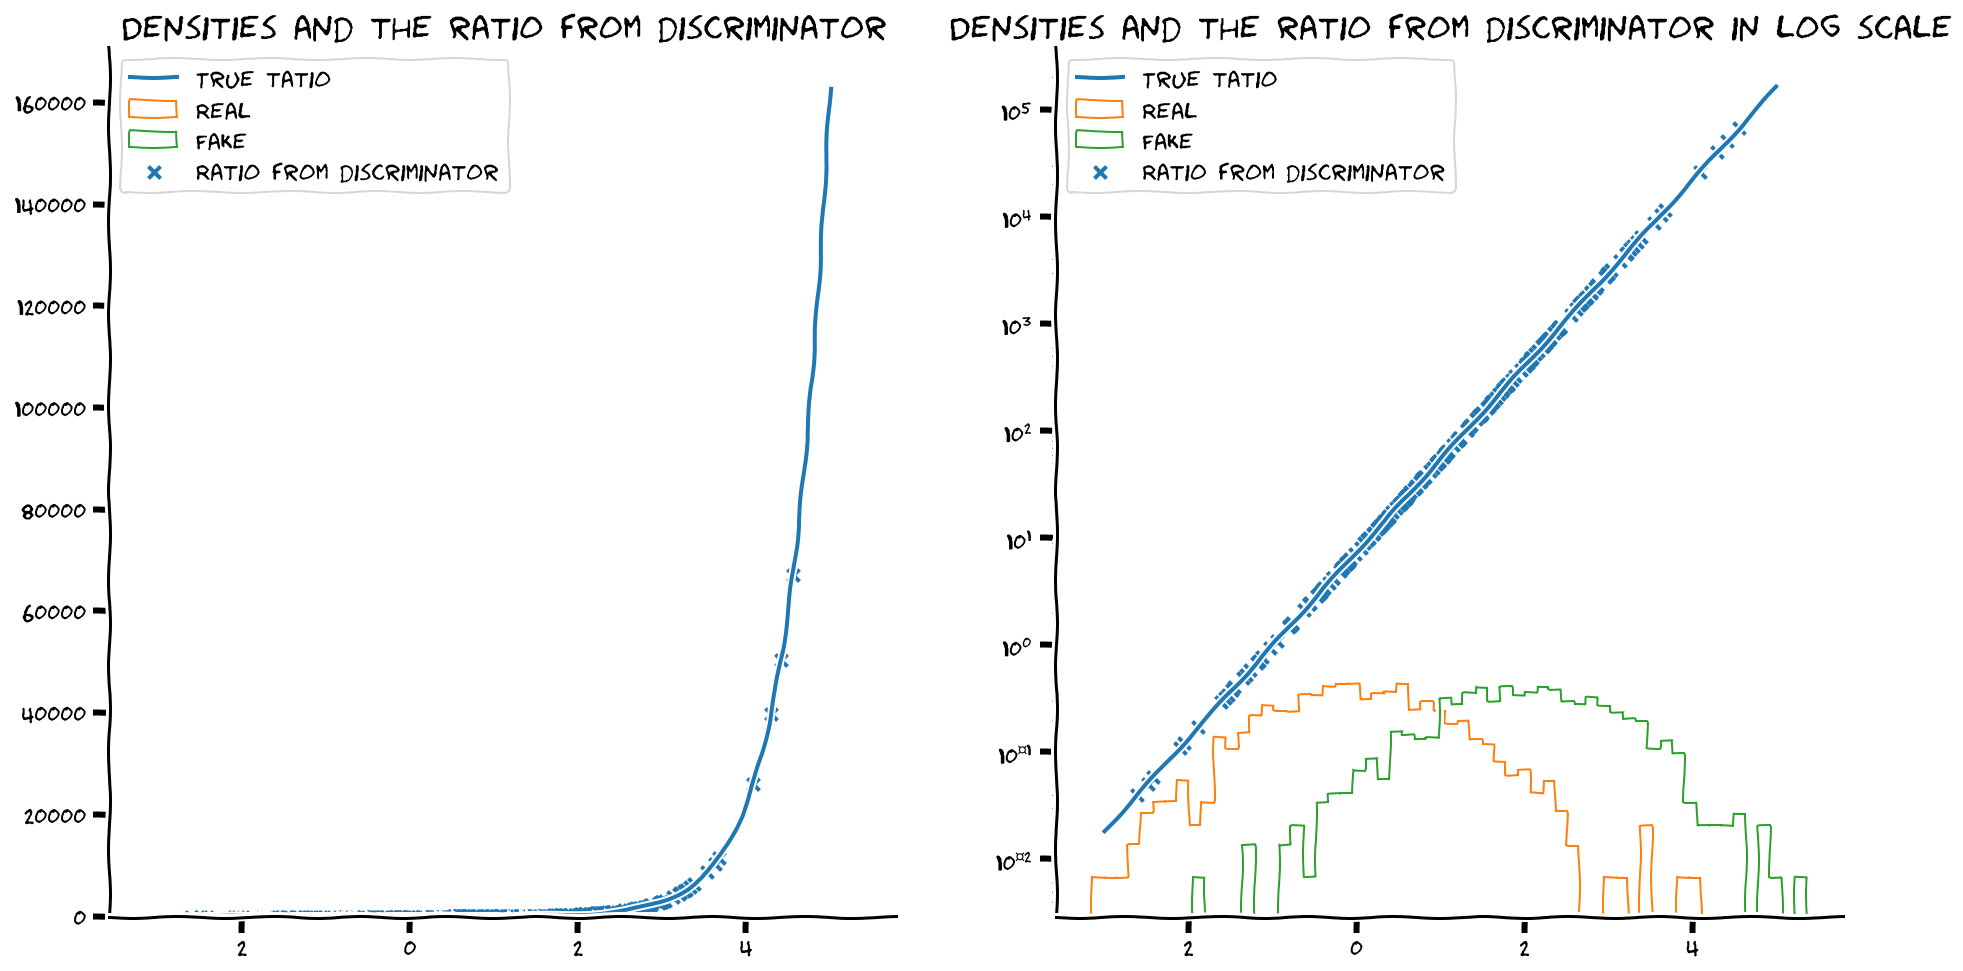

In [14]:
disc = OptimalDisc()
gen = DummyGen()

x_real = get_data(1_000)
x_fake = gen.sample(1_000)
ratio = ratio_disc(disc, x_real, x_fake)

with plt.xkcd():  
  plotting_ratio(x_real, x_fake, ratio)

## Section 1.3:  The generator loss

Now that we have a trained critic, lets see how to train the generator using it.

### Coding Exercise 1.3: The generator loss

We will now implement the generator loss function and evaluate it on some fixed points.

__Your goal__ is to complete the implementation of the function `loss_gen` using the optimal critic from above.

Upon correct implementation, you shall see a plot where the loss values from generator samples align with the "Correct" values.

In [15]:
def loss_gen(disc, x_fake):
  """Compute the generator loss for `x_fake` given `disc`
  
  Args:
    disc: The generator
    x_fake (ndarray): An array of shape (N,) that contains the fake samples

  Returns:
    ndarray: The generator loss
  """

  #################################################
  # TODO for students:                            #
  # Fill out ... in the function and remove below #
  #################################################

  #################################################
  # TODO for students: Loss for fake data
  #################################################
  label_fake = ...
  loss_fake = label_fake * ...

  raise NotImplementedError("Student exercise: Implement loss for fake data")

  return loss_fake

In [16]:
# to_remove solution
def loss_gen(disc, x_fake):
  """Compute the generator loss for `x_fake` given `disc`
  
  Args:
    disc: The generator
    x_fake (ndarray): An array of shape (N,) that contains the fake samples

  Returns:
    ndarray: The generator loss
  """

  # Loss for fake data
  label_fake = 1
  loss_fake = label_fake * torch.log(disc.classify(x_fake))

  return loss_fake

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


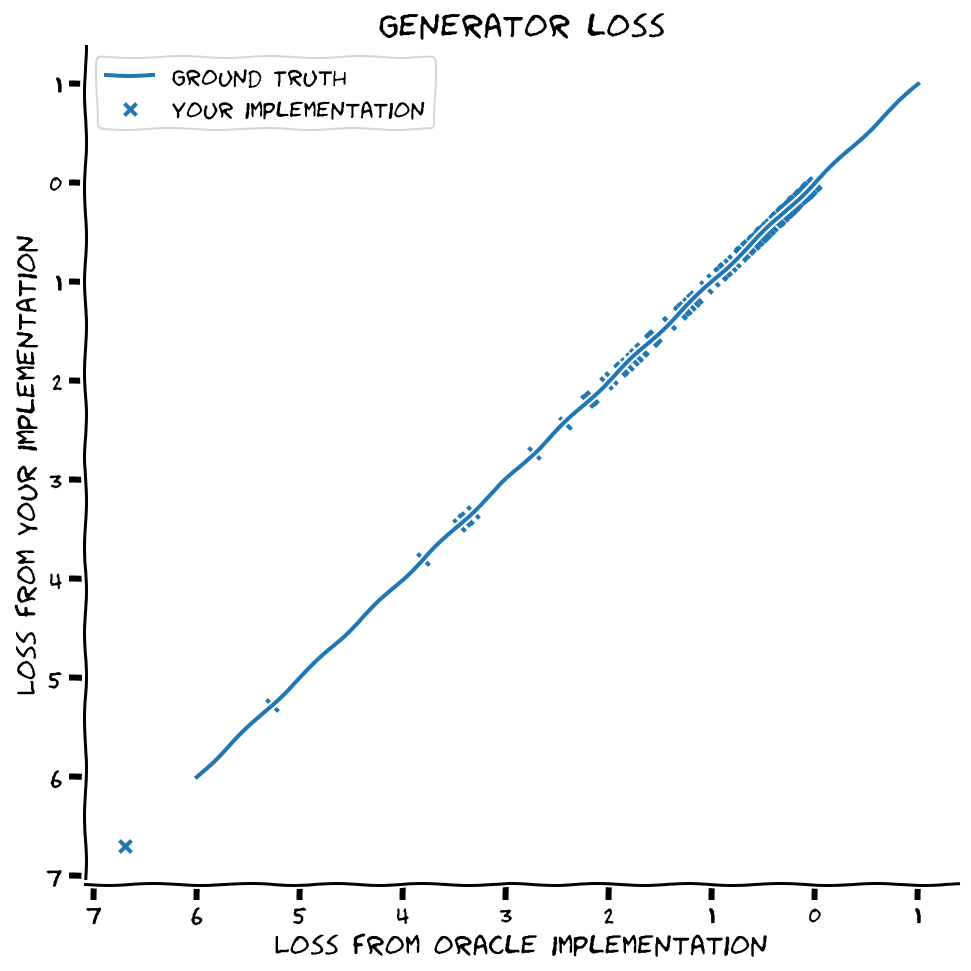

In [17]:
disc = DummyDisc()
gen = DummyGen()

x_fake = gen.sample()
lg = loss_gen(disc, x_fake)

with plt.xkcd():  
  plotting_lg(lg)

#### Did you notice?

The loss you implemented for generator is essentially the part for real data in `loss_disc`, i.e. it is saying, "the data I am feeding to you is real and not fake".

---

# Section 2: GAN training in action!

In this section we will be playing with a complete implementation of GAN.

# Interactive Demo 2: GAN training in action



In [18]:
# @markdown *Execute this cell to enable the implemented GAN*
# @markdown
# @markdown You are encouraged to take a look at the implementation as well.

class Generator(nn.Module):
    def __init__(self, latent_dim, layers, output_activation=None):

        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.output_activation = output_activation
        self._init_layers(layers)

    def _init_layers(self, layers):
        """Initialize the layers and store as self.module_list."""
        self.module_list = nn.ModuleList()
        last_layer = self.latent_dim
        for index, width in enumerate(layers):
            self.module_list.append(nn.Linear(last_layer, width))
            last_layer = width
            if index + 1 != len(layers):
                self.module_list.append(nn.LeakyReLU())
        else:
            if self.output_activation is not None:
                self.module_list.append(self.output_activation())

    def forward(self, input_tensor):
        """Forward pass; map latent vectors to samples."""
        intermediate = input_tensor
        for layer in self.module_list:
            intermediate = layer(intermediate)
        return intermediate


class Discriminator(nn.Module):
    def __init__(self, input_dim, layers):
 
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self._init_layers(layers)

    def _init_layers(self, layers):
        """Initialize the layers and store as self.module_list."""
        self.module_list = nn.ModuleList()
        last_layer = self.input_dim
        for index, width in enumerate(layers):
            self.module_list.append(nn.Linear(last_layer, width))
            last_layer = width
            if index + 1 != len(layers):
                self.module_list.append(nn.LeakyReLU())
        else:
            self.module_list.append(nn.Sigmoid())

    def forward(self, input_tensor):
        """Forward pass; map samples to confidence they are real [0, 1]."""
        intermediate = input_tensor
        for layer in self.module_list:
            intermediate = layer(intermediate)
        return intermediate

class VanillaGAN():
    def __init__(self, generator, discriminator, noise_fn, data_fn,
                 batch_size=100, device='cpu', lr_d=1e-3, lr_g=2e-4):
      
        self.generator = generator
        self.generator = self.generator.to(device)
        self.discriminator = discriminator
        self.discriminator = self.discriminator.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.batch_size = batch_size
        self.device = device
        self.criterion = nn.BCELoss()
        self.optim_d = optim.Adam(discriminator.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)

    def generate_samples(self, latent_vec=None, num=None):
        """Sample from the generator.
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        return samples

    def real_data(self, num=None):
        """Real Data
        """
        num = self.batch_size if num is None else num
        with torch.no_grad():
            samples = self.data_fn(num)
        return samples

    def train_step_generator(self):
        """Train the generator one step and return the loss."""
        self.generator.zero_grad()

        latent_vec = self.noise_fn(self.batch_size)
        generated = self.generator(latent_vec)
        classifications = self.discriminator(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_g.step()
        return loss.item()

    def train_step_discriminator(self):
        """Train the discriminator one step and return the losses."""
        self.discriminator.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        pred_real = self.discriminator(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec)
        pred_fake = self.discriminator(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_d.step()
        return loss_real.item(), loss_fake.item()

    def train_step(self):
        """Train both networks and return the losses."""
        loss_d = self.train_step_discriminator()
        loss_g = self.train_step_generator()
        return loss_g, loss_d


def train(mean=0.,sigma=.2):
    epochs = 30
    batches = 100
    generator = Generator(2, [64, 32, 2])
    discriminator = Discriminator(2, [64, 32, 1])
    noise_fn = lambda x: torch.rand((x, 2), device='cpu')
    data_fn = lambda x: mean+sigma*torch.randn((x, 2), device='cpu')
    gan = VanillaGAN(generator, discriminator, noise_fn, data_fn, lr_d=1e-3, lr_g=2e-4, device='cpu')
    loss_g, loss_d_real, loss_d_fake = [], [], []
    start = time()

    fig, ax = plt.subplots(1, 1,figsize=(5,5))
    x, y = np.random.random((2, 200))
    data_scat = ax.scatter(x,y,label='Data',alpha=0.9,s=10.,c='r')
    gan_scat = ax.scatter(x,y,label='GAN',alpha=0.9,s=10.,c='b')
    ax.legend()
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    for epoch in range(epochs):
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for batch in range(batches):
            lg_, (ldr_, ldf_) = gan.train_step()
            loss_g_running += lg_
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_
        loss_g.append(loss_g_running / batches)
        loss_d_real.append(loss_d_real_running / batches)
        loss_d_fake.append(loss_d_fake_running / batches)
        print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
              f" G={loss_g[-1]:.3f},"
              f" Dr={loss_d_real[-1]:.3f},"
              f" Df={loss_d_fake[-1]:.3f}")
   
        gan_scat.set_offsets(gan.generate_samples())
        data_scat.set_offsets(gan.real_data())
        
        clear_output(wait=True)
        display(fig)

Notice in the implementaiton above, we use `torch.nn.BCELoss` to implement the discriminator and generator loss with proper "labels".
They are actually equivalent to your implementation - do you want to varify this fact?

In [19]:
#@title The demo
# https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html
slider_mean = ipywidgets.FloatSlider(value=0., min=-1, max=1, step=.1, readout_format='.5f', description="Set Target Mean", style={'description_width': 'initial'})
slider_sigma = ipywidgets.FloatSlider(value=.2, min=.2, max=1., step=.1, readout_format='.5f', description="Set Target Sigma", style={'description_width': 'initial'})
button = ipywidgets.Button(description="Start Training!")
output = ipywidgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    train(slider_mean.value, slider_sigma.value)

button.on_click(on_button_clicked)
display(slider_mean, slider_sigma, button, output)

FloatSlider(value=0.0, description='Set Target Mean', max=1.0, min=-1.0, readout_format='.5f', style=SliderSty…

FloatSlider(value=0.2, description='Set Target Sigma', max=1.0, min=0.2, readout_format='.5f', style=SliderSty…

Button(description='Start Training!', style=ButtonStyle())

Output()

---
# Summary

Through this tutorial we have learned

- How to implement the training objectives for the generator and discriminator of GANs.
- How are GANs connected to density ratio estimation

Next tutorial will cover conditional GANs.